## Desenvolvimento das funções

In [1]:
###AVISO::: TEM QUE SUBSTITUIR O RANGE (linha 19) PARA NÃO TER DUPLICATAS, VISTO QUE O SITE RETORNA PARA A 
### PRIMEIRA PÁGINA SE ELE NÃO ACHAR A PÁGINA QUE PROCUROU

###Como tem anúncios patrocinados no site que estarão de volta ao topo em toda lista, temos que remover as duplicatas

#Biblioteca para a mineração de dados
from bs4 import BeautifulSoup

#Biblioteca para lidar com o HTTP 
import requests

#Biblioteca para exportar para csv
import pandas as pd

#Bibliotecas para visualização gráfica dos dados
import seaborn as sns 
import matplotlib.pyplot as plt

class Formatador:
    def __init__(self,df):
        self.df = df
        
    #Função para remover espaços brancos do dataframe
    def remover_espacos(self):
        df_obj = self.df.select_dtypes(['object'])
        self.df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    
    #Função para retirar o tipo de casa da coluna Titulo e separar em duas colunas novas
    def separar_tipo_casa(self):
        self.df[['Tipo_De_Casa', 'Nome']] = self.df['Titulo'].str.split(' ', 1, expand=True)
        self.df.drop(columns=['Titulo'], inplace=True)
    
    #Função para retirar o permonth da coluna Preço e transformar ela em numérica 
    def arrumar_preco(self):
        series = self.df['Preco']
        preco_numerico = series.str.strip('€per month')
        preco_sem_virgula = preco_numerico.str.replace(',', '')
        self.df['Preco_Em_Euros'] = pd.to_numeric(preco_sem_virgula)
        self.df.drop(columns=['Preco'], inplace=True)
    
    #Função para limpar a coluna localização e separar entre número da casa e lugar dela
    def limpar_localizacao(self):
        series = self.df['Localizacao']
        lista_numeros = []
        lista_localizacoes = []
    
        for entrada in series.str.split():
            lista_numeros.append(entrada[0])
            lista_localizacoes.append(entrada[3].strip('()'))
    
        self.df['Numero_Do_Imovel'] = pd.to_numeric(lista_numeros)
        self.df['Localizacao_Do_Imovel'] = lista_localizacoes
        self.df.drop(columns=['Localizacao'], inplace=True)

    #Função para separar as informações da coluna Tamanho
    def limpar_tamanho(self):
        series = self.df['Tamanho']
        lista_tamanhos = []
        lista_quartos = []
        lista_mobiliados = []

        for valor in series.str.split():
            lista_tamanhos.append(valor[0])
            lista_quartos.append(valor[1][-1])
    
            if ('Furnished' in valor[2]) & ('Upholstered' in valor[2]):
                lista_mobiliados.append('Mobiliado e Estofado')
    
            elif 'Furnished' in valor[2]:
                lista_mobiliados.append('Mobiliado')
    
            elif 'Upholstered' in valor[2]:
                lista_mobiliados.append('Estofado')
    
            else:
                lista_mobiliados.append('Sem Mobilia')
    
        self.df['Tamanho_Do_Imovel_Em_MetrosQuadrados'] = pd.to_numeric(lista_tamanhos)
        self.df['Numero_De_Quartos'] = pd.to_numeric(lista_quartos)
        self.df['Mobiliado'] = lista_mobiliados

        self.df.drop(columns=['Tamanho'], inplace=True)

    def dropar_duplicados(self):
        self.df = self.df.drop_duplicates(inplace=True)
    
    def realizar_formatacao(self):
        self.remover_espacos()
        self.separar_tipo_casa()
        self.arrumar_preco()
        self.limpar_localizacao()
        self.limpar_tamanho()
        self.dropar_duplicados()
        

#Criando o dataframe 
casas = pd.DataFrame(columns=['Titulo', 'Localizacao', 'Preco', 'Tamanho'])

#Contador para ir para as próximas páginas, mas é necessário contar quantas páginas tem e substituir no range
for contador in range(18):
    url = f'https://www.pararius.com/apartments/amsterdam/page-{contador}'

    page = requests.get(url)
    #Aqui é importante dar um print(page) para ver se o request é 200, ou seja, se deu certo o request para a página

    soup = BeautifulSoup(page.content, 'html.parser')
    lists = soup.find_all('section')

    for list in lists:
        title = list.find('a', class_ = 'listing-search-item__link--title').text.replace('\n', '')
        location = list.find('div', class_ = 'listing-search-item__sub-title').text.replace('\n', '')
        price = list.find('div', class_ = 'listing-search-item__price').text.replace('\n', '')
        size = list.find('ul', class_ = 'illustrated-features').text.replace('\n', '')
        info = [title, location, price, size]
        casas.loc[len(casas.index)] = info

formatador = Formatador(casas)
formatador.realizar_formatacao()

## Visualização gráfica das colunas

In [43]:
display(casas)

,Tipo_De_Casa,Nome,Preco_Em_Euros,Numero_Do_Imovel,Localizacao_Do_Imovel,Tamanho_Do_Imovel_Em_MetrosQuadrados,Numero_De_Quartos,Mobiliado
0,Apartment,Weteringschans,2200,1017,De,70,3,Estofado
1,Apartment,Rhijnvis Feithstraat,1875,1054,Overtoomse,54,2,Mobiliado
2,Apartment,Van Boetzelaerstraat,1650,1051,Staatsliedenbuurt,44,2,Mobiliado
3,Apartment,Noorderstraat,1850,1017,De,65,3,Mobiliado
4,Apartment,Jan Bernardusstraat,2100,1091,Weesperzijde,55,2,Mobiliado
...,...,...,...,...,...,...,...,...
553,Apartment,Esplanade de Meer,2500,1098,Middenmeer,96,3,Mobiliado
554,Apartment,NDSM-kade,1694,1033,Noordelijke,89,2,Estofado
555,Apartment,NDSM-kade,1568,1033,Noordelijke,64,2,Estofado
556,Apartment,NDSM-kade,1265,1033,Noordelijke,63,2,Estofado


<AxesSubplot:xlabel='Preco_Em_Euros', ylabel='Número de Apartamentos'>

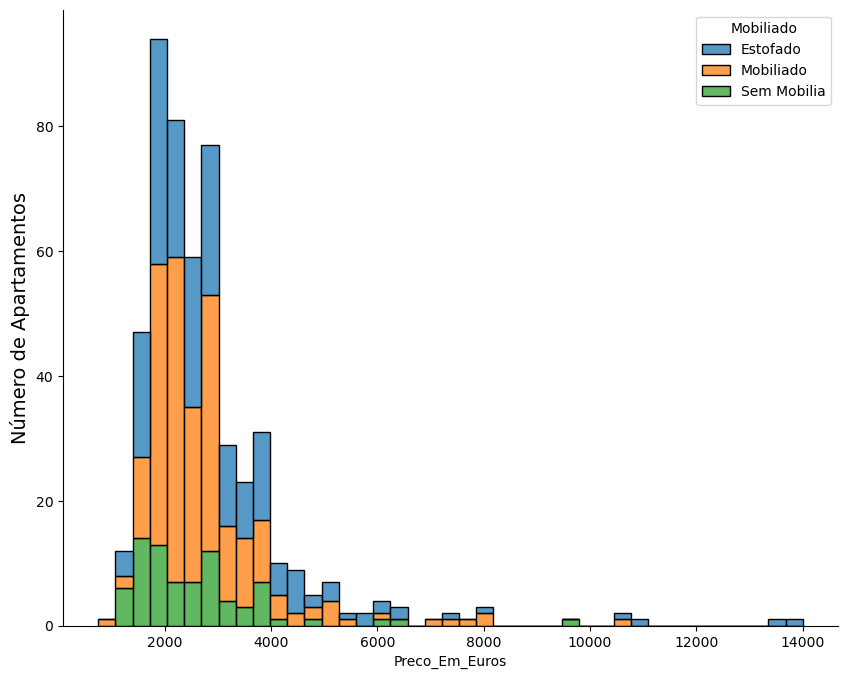

In [3]:
fig, ax = plt.subplots(figsize=(10,8))
sns.despine(fig)
plt.ylabel('Número de Apartamentos', fontsize=14)

sns.histplot(data=casas, x='Preco_Em_Euros', hue='Mobiliado', multiple='stack')

<AxesSubplot:xlabel='Tipo_De_Casa', ylabel='count'>

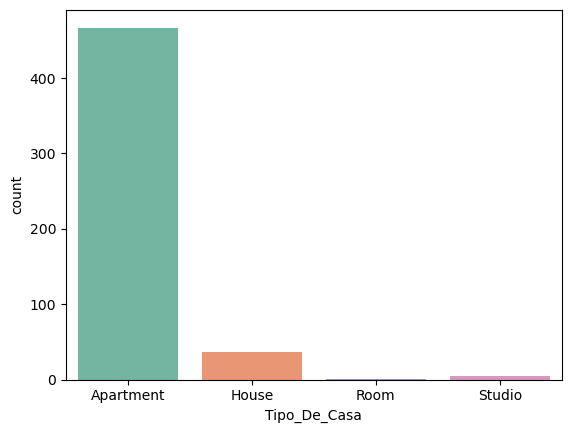

In [4]:
sns.countplot(x='Tipo_De_Casa', palette='Set2', data=casas)

<AxesSubplot:title={'center':'Oito localizações com mais lugares a venda'}, xlabel='Localizacao_Do_Imovel'>

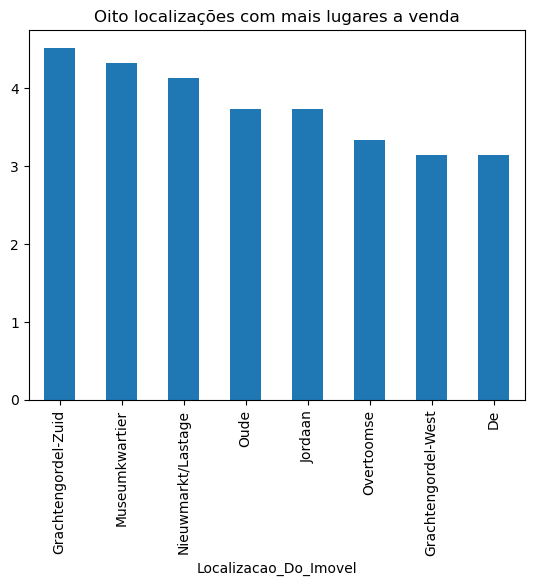

In [11]:
#Oito localizações com mais lugares a venda
plt.title('Oito localizações com mais lugares a venda')
((casas.value_counts('Localizacao_Do_Imovel', normalize=True)) * 100).nlargest(8).plot(kind='bar')


In [14]:
#As localizações com as médias mais caras para se morar
casas.drop(
    columns=['Numero_Do_Imovel']).groupby(
    by='Localizacao_Do_Imovel').mean().astype(int).sort_values(
    'Preco_Em_Euros', ascending=False)

,Preco_Em_Euros,Tamanho_Do_Imovel_Em_MetrosQuadrados,Numero_De_Quartos
Localizacao_Do_Imovel,,,
Zuidas,4828,130,3
Willemspark,4586,144,3
De,4068,143,3
Omval/Overamstel,3962,139,4
Museumkwartier,3911,139,4
...,...,...,...
Geuzenveld,1727,85,3
Chassébuurt,1500,60,2
Buikslotermeer,1452,63,2


# Desenvolvendo o modelo de machine learning

### Importando as bibliotecas utilizadas

In [2]:
#Separar os dados em treino/teste
from sklearn.model_selection import train_test_split

#Escalonamento dos dados 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

#Regressores utilizados no MLA (Machine Learning Algorithm)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

#Métricas de qualidade do modelo 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Cronometrar a run time de cada modelo 
from time import time

#Operações matemáticas 
import numpy as np

#Retirando a opção de mostrar a notação cientifica dentro dos dataframes 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Retirando as colunas que não agregam valor ao modelo, e transformando as colunas categóricas em numéricas

In [3]:
casas.drop(columns=['Nome'], inplace=True)
casas = pd.get_dummies(casas, columns=['Tipo_De_Casa', 'Localizacao_Do_Imovel', 'Mobiliado'])

### Separando os dados em treino e teste (80-20)

In [6]:
X = casas.drop(columns=['Preco_Em_Euros'])
y = casas['Preco_Em_Euros']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X, y, test_size=0.50, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_validation.shape)
print(y_validation.shape)

(407, 81)
(407,)
(254, 81)
(254,)
(255, 81)
(255,)


### Verificando o comportamento dos escalonadores de dados no dataset

In [ ]:
casas.drop(columns=['Nome'], inplace=True)
casas = pd.get_dummies(casas, columns=['Tipo_De_Casa', 'Localizacao_Do_Imovel', 'Mobiliado'])

scalers = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler()
]

### Desenvolvimento do MLA (Machine Learning Algorithm) para verificar como os diferentes tipos de scalers e modelos atuam no nosso conjunto de dados

In [5]:
models = [
    RandomForestRegressor(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    XGBRegressor(),
    CatBoostRegressor(verbose=0),
    LGBMRegressor(),
    DecisionTreeRegressor(),
    MLPRegressor(),
    KNeighborsRegressor(),
    SVR(),
    GaussianProcessRegressor()
]

#Criando as listas vazias das métricas e parâmetros dos modelos
MAE = []
RMSE = []
MSE = []
r2 = []
names = []
parameters = []
tempo = [] 

#Testando modelo por modelo e adicionando os resultados nas listas
for model in models:
    #Começando o cronometro de duração de run do modelo
    tempo_inicial = time()
    
    #Treinando o modelo e fazendo o predict no conjunto de teste
    regressor = model.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    #Adicionando o valor da métrica de cada modelo para criar o dataframe depois
    MAE.append(mean_absolute_error(y_test, y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    MSE.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))
    
    #Para pegar o nome e os parâmetros do modelo basta usar o método de classe
    names.append(model.__class__.__name__)    
    parameters.append(model.get_params())
               
    #Parando o cronometro para ver o tempo e adicionando na lista 
    tempo_final = time() - tempo_inicial
    tempo.append(tempo_final)
    
#Criando um dataframe com os valores dos modelos testados 
resultado = pd.DataFrame({'Nome': names,
                         'Parametros': parameters,
                         'MAE': MAE,
                         'RMSE': RMSE,
                         'MSE': MSE,
                         'R2': r2,
                         'Run Time': tempo})

resultado.sort_values(by='R2', ascending=False)

C:\Users\Pc\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Nome,Parametros,MAE,RMSE,MSE,R2,Run Time
2,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",480.837,959.129,919928.669,0.637,0.010
3,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",483.120,963.077,927518.148,0.634,0.006
5,CatBoostRegressor,"{'loss_function': 'RMSE', 'verbose': 0}",448.945,986.829,973831.888,0.616,1.086
4,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",522.184,994.823,989673.514,0.609,0.168
9,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",528.641,994.954,989934.062,0.609,0.006
0,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",505.080,995.127,990278.702,0.609,0.210
6,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",524.023,1069.359,1143529.578,0.549,0.055
7,DecisionTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",624.484,1167.728,1363589.808,0.462,0.007
8,MLPRegressor,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",810.827,1434.622,2058138.964,0.188,0.358
10,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",874.535,1621.253,2628459.814,-0.037,0.023


## Escolhendo os três melhores modelos e realizando o tuning dos hiperparâmetros para escolher o melhor entre esses três 

In [9]:
regressor = CatBoostRegressor(iterations=1500, learning_rate=0.01, depth=10, eval_metric='RMSE',
                             random_seed=42, bagging_temperature=0.2, od_type='Iter',
                             metric_period=50, od_wait=20)
regressor.fit(X_train, y_train, eval_set=(X_validation, y_validation), use_best_model=True, verbose=0)
y_pred = regressor.predict(X_test)

print(mean_squared_error(y_pred, y_test))
print(r2_score(y_pred, y_test))

80375.53677363781
0.9642242965218563


## Verificando como nosso modelo performa nos dados de teste comparados com os dados reais 

In [11]:
resultado_catboost = pd.DataFrame({'Valores Reais': y_test,
                                  'Valores Preditos': y_pred})

resultado_catboost.sample(10)

,Valores Reais,Valores Preditos
413,3300,3273.700
373,2795,2759.259
208,3100,3143.651
476,2950,3008.173
372,3000,2829.782
290,1900,2210.313
91,2250,2186.151
20,2500,2795.301
80,1875,2274.742
486,4000,4195.753
